In [2]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_84521/889999587.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
excel_df = pd.read_excel('/Users/franhuzjan/Downloads/BBM_Projections (2).xls')

excel_df.head()

,Own,Round,Rank,Y!Adp,Y!XRank,Y!%,Adv%,Adv+-,Value,PosV,...,to/g,pV,3V,rV,aV,sV,bV,fg%V,ft%V,toV
0,NaN,1,1,1.1,1,100,NaN,NaN,0.778896,0.719067,...,3.401408,1.055063,-0.877221,2.460704,2.409955,0.678968,0.100854,2.697567,0.399118,-1.914940
1,NaN,1,2,3.3,3,100,NaN,NaN,0.676339,0.616510,...,3.253485,2.384650,-0.502896,1.907958,0.094695,0.036617,1.294654,1.147783,1.449690,-1.726096
2,NaN,1,3,6.5,6,100,NaN,NaN,0.659237,0.666172,...,2.628592,0.826100,1.239541,-1.010348,3.217480,2.021362,-0.335108,-0.010159,0.912605,-0.928339
3,NaN,1,4,5.6,4,100,NaN,NaN,0.641944,0.648880,...,2.776515,2.317415,-0.659871,-0.449837,0.538288,1.912551,0.117180,0.355444,2.763509,-1.117183
4,NaN,1,5,6.5,7,100,NaN,NaN,0.619093,0.582787,...,3.154394,2.026233,2.956062,-0.236332,0.943426,0.497660,-0.610754,-0.312833,1.907970,-1.599594


In [5]:
for column in excel_df.columns:
    print(column)

Own
Round
Rank
Y!Adp
Y!XRank
Y!%
Adv%
Adv+-
Value
PosV
MonsterBar<small class="ml-1">game</small>
Name
Team
Pos
Note
Inj
Inj Risk
Status
Conf
Role
g
QG
b2b
m/g
p/g
3/g
r/g
a/g
s/g
b/g
fg%
fga/g
ft%
fta/g
to/g
pV
3V
rV
aV
sV
bV
fg%V
ft%V
toV


In [6]:
# First task - Rank vs ADP

columns_to_keep = ['Rank', 'Y!Adp', 'Y!XRank', 
                   'Value',
                   # 'PuntV',
                   'Name']

df = excel_df[columns_to_keep]

df = df.drop(df[df['Y!Adp'] <= 0].index)

df

,Rank,Y!Adp,Y!XRank,Value,Name
0,1,1.1,1,0.778896,Nikola Jokic
1,2,3.3,3,0.676339,Joel Embiid
2,3,6.5,6,0.659237,Tyrese Haliburton
3,4,5.6,4,0.641944,Shai Gilgeous-Alexander
4,5,6.5,7,0.619093,Stephen Curry
...,...,...,...,...,...
181,182,146.2,225,-0.430168,Christian Braun
182,183,138.1,145,-0.440237,Isaiah Stewart
183,184,134.9,252,-0.441061,Malik Beasley
184,185,145.0,142,-0.442088,Gordon Hayward


In [7]:
sleepers = df.copy()

sleepers['ADP-ProjRank'] = df['Y!Adp'] - df['Rank']
sleepers['ADP-YXRank'] = df['Y!Adp'] - df['Y!XRank']

sleepers = sleepers.sort_values(by=['ADP-ProjRank', 'ADP-YXRank'], ascending=False)

sleepers.replace("Kevin Porter", "Kevin Porter Jr.", inplace=True)
sleepers.replace("Nicolas Claxton", "Nic Claxton", inplace=True)
sleepers.replace("Herb Jones", "Herbert Jones", inplace=True)
sleepers.replace("C.J. McCollum", "CJ McCollum", inplace=True)
sleepers.replace("PJ Washington", "P.J. Washington", inplace=True)
sleepers.replace("Gary Trent", "Gary Trent Jr.", inplace=True)



sleepers.tail(10)

# len(sleepers[np.abs(sleepers['ADP-ProjRank']) < 1])

,Rank,Y!Adp,Y!XRank,Value,Name,ADP-ProjRank,ADP-YXRank
187,188,142.0,172,-0.458479,Gabe Vincent,-46.0,-30.0
176,177,130.8,119,-0.395558,Collin Sexton,-46.2,11.8
155,156,109.4,116,-0.335161,Bobby Portis,-46.6,-6.6
131,132,84.0,86,-0.268104,Kyle Kuzma,-48.0,-2.0
178,179,129.9,177,-0.409536,Brandon Miller,-49.1,-47.1
183,184,134.9,252,-0.441061,Malik Beasley,-49.1,-117.1
64,65,7.1,8,0.000836,Giannis Antetokounmpo,-57.9,-0.9
123,124,58.1,63,-0.219983,Paolo Banchero,-65.9,-4.9
144,145,77.9,74,-0.299183,Jalen Green,-67.1,3.9
175,176,97.2,107,-0.392345,Scoot Henderson,-78.8,-9.8


0 Bust Scoot Henderson 1630703 176
1 Bust Jalen Green 1630224 145
2 Bust Paolo Banchero 1631094 124
3 Bust Giannis Antetokounmpo 203507 65
4 Bust Malik Beasley 1627736 184
5 Bust Brandon Miller 1641706 179
6 Bust Kyle Kuzma 1628398 132
7 Bust Bobby Portis 1626171 156
8 Bust Collin Sexton 1629012 177
9 Bust Gabe Vincent 1629216 188


Text(65.5, 179.5, '@FHuzjan')

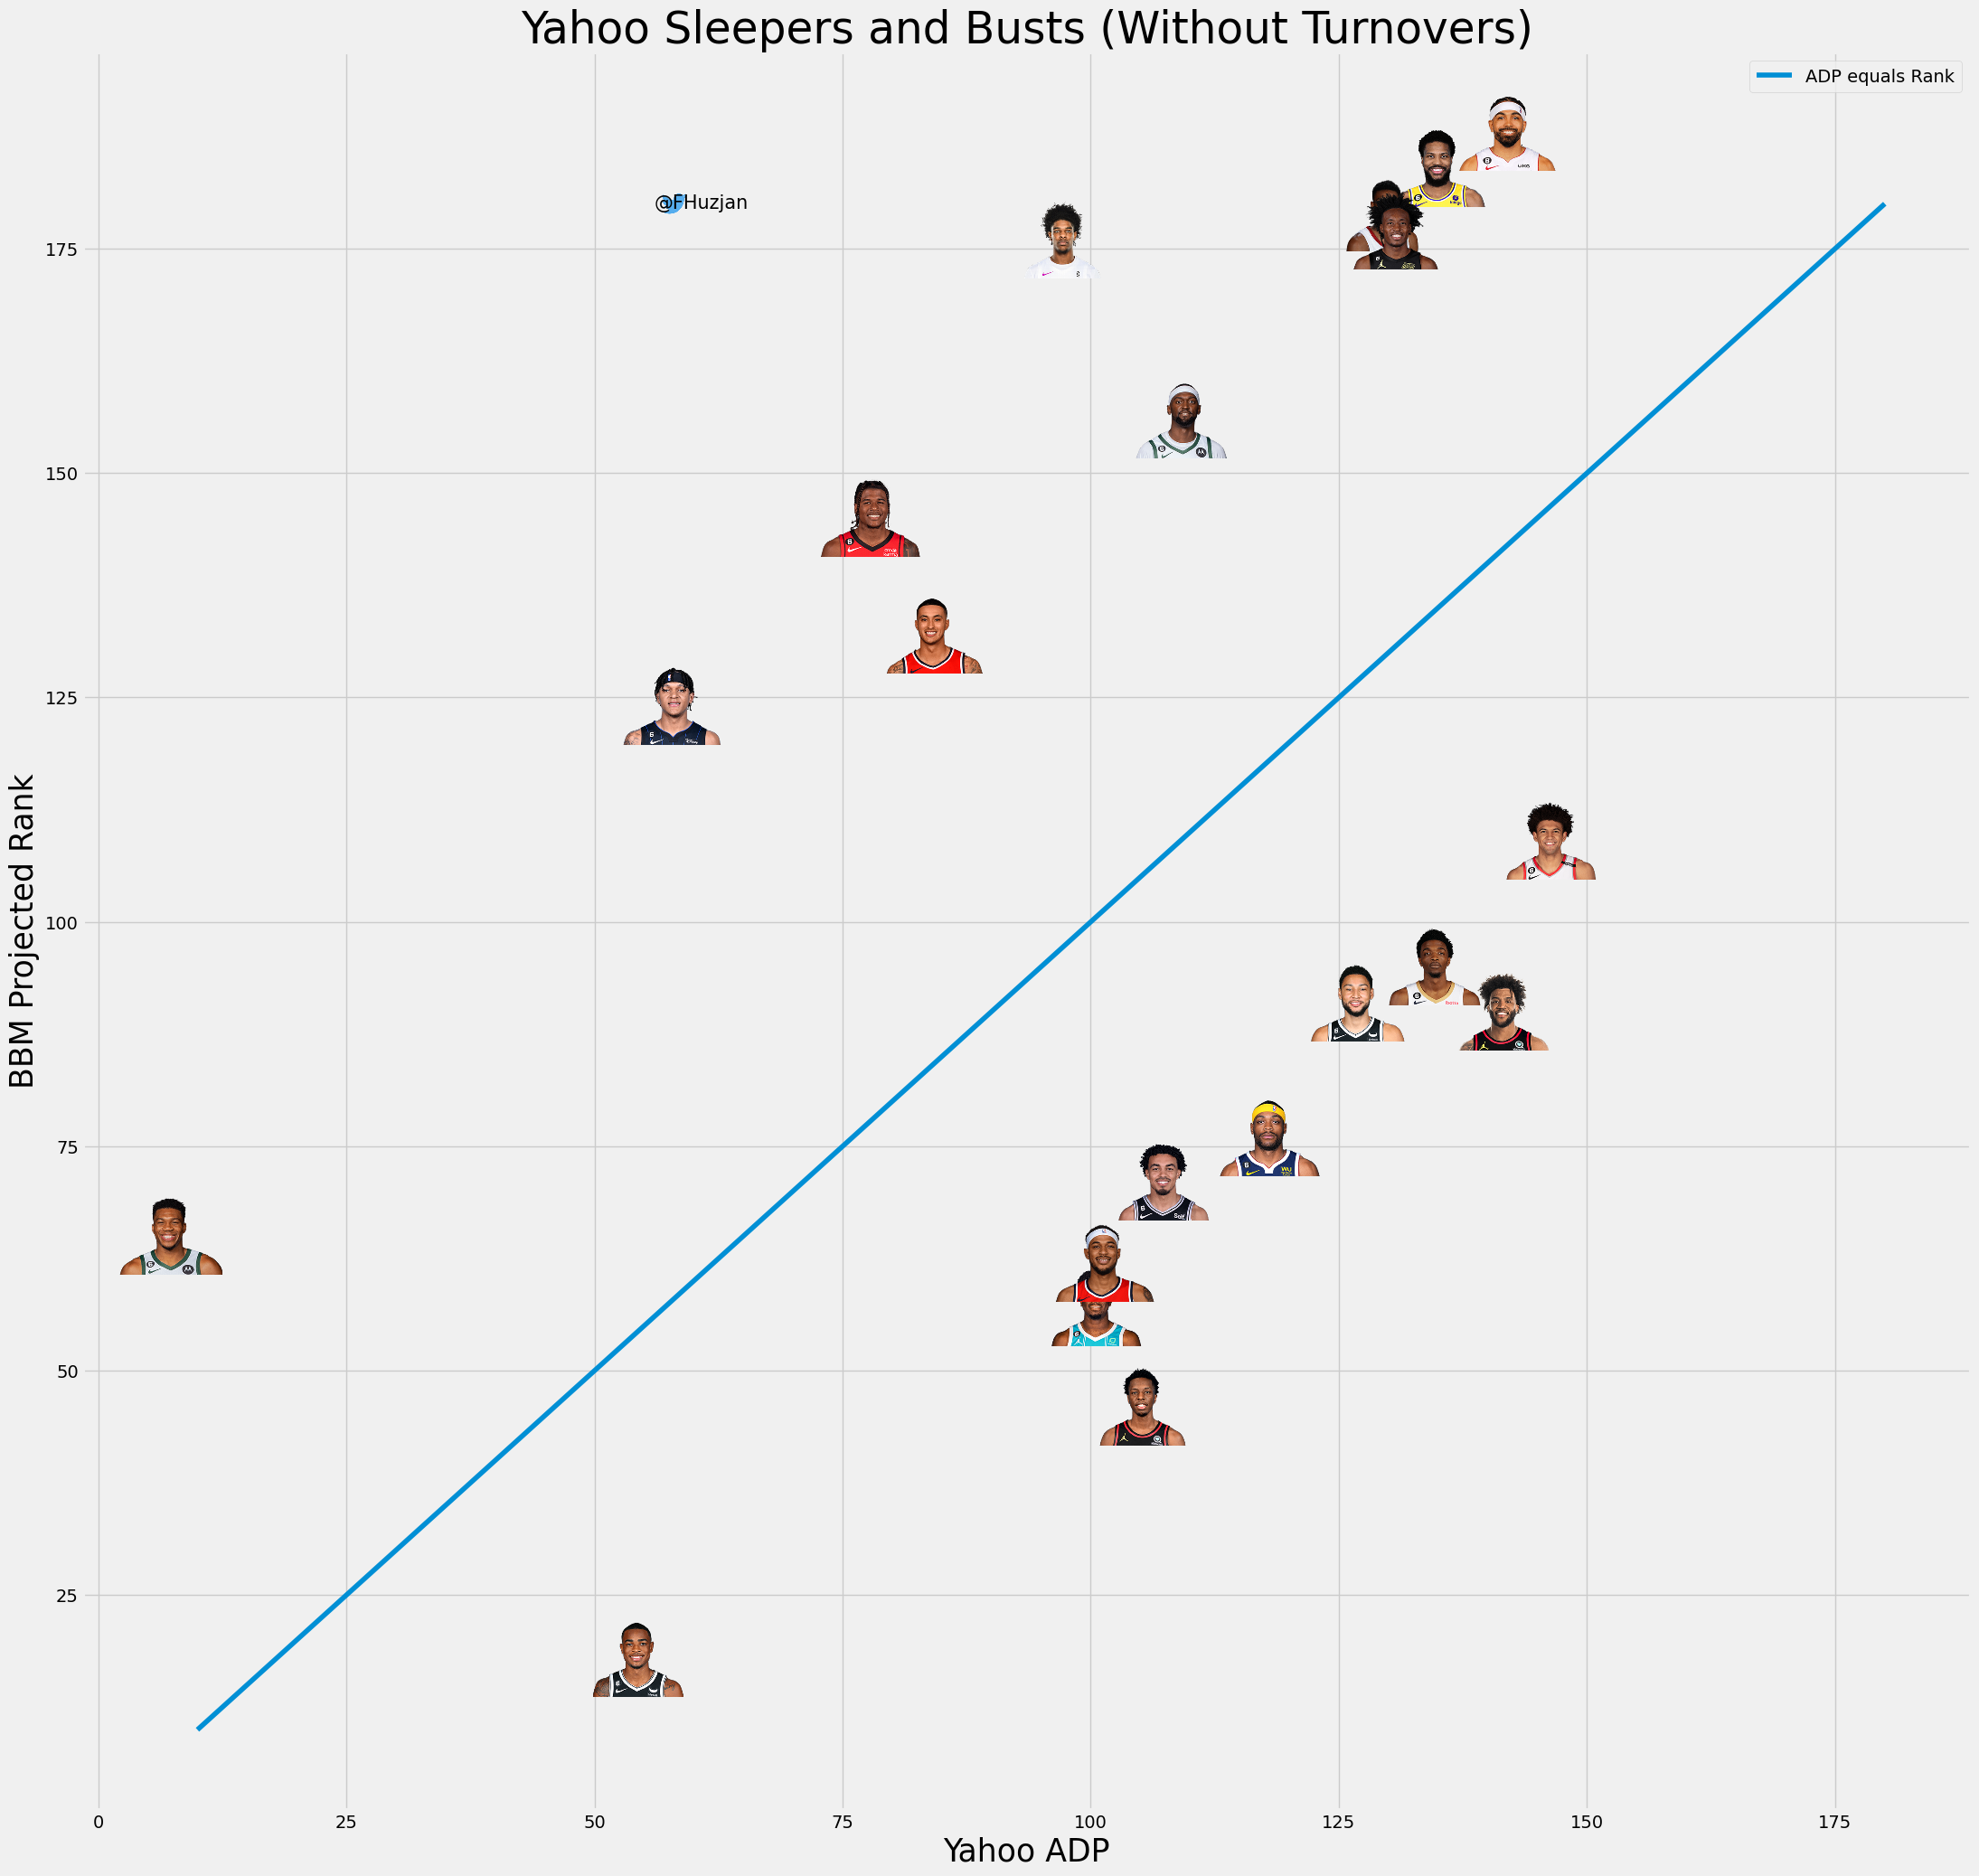

In [10]:
fig, ax = plt.subplots(figsize=(24, 24))

zoom = 0.325
player_root_dir = 'player_imgs/'

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

ax.plot([10, 180], [10, 180], label='ADP equals Rank')

previous_id = 0

for i in range(10):
    sleeper = sleepers.iloc[i]
    
    try:
        sleeper_id = find_players_by_full_name(sleeper['Name'])[0]['id']
        # print('Sleeper', sleeper['Name'], sleeper_id, sleeper['Rank'])

    except:
        if sleeper['Name'] == 'Scoot Henderson':
            sleeper_id = 1630703
        if sleeper['Name'] == 'Ausar Thompson':
            sleeper_id = 1641709
            
    previous_id = sleeper_id
    
    ab = AnnotationBbox(get_player_img(sleeper_id), (sleeper['Y!Adp'], sleeper['Rank']), frameon=False)
    ax.add_artist(ab)
    
    ax.scatter(sleeper['Y!Adp'], sleeper['Rank'], color='r')
    
    # print(sleeper['Rank'], sleeper['Name'])
    # print(bust['Rank'], bust['Name'])
    
for i in range(10):
    bust = sleepers.iloc[-i - 1]

    try:
        bust_id = find_players_by_full_name(bust['Name'])[0]['id']
        print(i, 'Bust', bust['Name'], bust_id, bust['Rank'])
    except:
        if bust['Name'] == 'Scoot Henderson':
            bust_id = 1630703
        if bust['Name'] == 'Brandon Miller':
            bust_id = 1641706
        if bust['Name'] == 'Jarace Walker':
            continue
        print(i, 'Bust', bust['Name'], bust_id, bust['Rank'])

        
            
    if previous_id == bust_id:
        print(bust['Name'])

    previous_id = bust_id
    
    
    ab = AnnotationBbox(get_player_img(bust_id), (bust['Y!Adp'], bust['Rank']), frameon=False)
    ax.add_artist(ab)
    
    ax.scatter(bust['Y!Adp'], bust['Rank'], color='b')
    
    # print(sleeper['Rank'], sleeper['Name'])
    # print(bust['Rank'], bust['Name'])
    
# for i in range(len(sleepers[np.abs(sleepers['ADP-ProjRank']) < 1])):
#     player = sleepers[np.abs(sleepers['ADP-ProjRank']) < 1].iloc[i]
    
#     print(player['Name'])
    
#     player_id = find_players_by_full_name(player['Name'])[0]['id']
    
#     ab = AnnotationBbox(get_player_img(player_id), (player['Y!Adp'], player['Rank']), frameon=False)
#     ax.add_artist(ab)
    

plt.legend()    
ax.set_xlabel("Yahoo ADP", fontsize=25)
ax.set_ylabel("BBM Projected Rank", fontsize=25)
ax.set_title("Yahoo Sleepers and Busts (Without Turnovers)", fontdict={'fontsize': 35})
ab = AnnotationBbox(OffsetImage(plt.imread(f'twitter_logo (1).png'), zoom=0.1), (58, 180), frameon=False)
ax.add_artist(ab)
ax.text(x=65.5, y=179.5, ha='right', s='@FHuzjan', size=15)

# plt.savefig('Graphs/sleepers_busts_without_TO.png', bbox_inches='tight')

In [ ]:
cats_dict = {'p/g':1.5,
             '3/g':0.25,
             'r/g':1,
             'a/g':0.5,
             's/g':0.1,
             'b/g':0.2,
             'fg%':0.05,
             'ft%':0.02,
             'to/g':0.25}



plt.figure(figsize=(20, 20))


for i, (cat, binwidth) in enumerate(cats_dict.items()):
    ax = plt.subplot(3, 3, i + 1)
    
    if '%' not in cat:
        range_ = int(max(excel_df[cat]) - min(excel_df[cat]))
        # binwidth = 0.5
        ax.hist(excel_df[cat], bins=int(range_ / binwidth), ec='black')
    else:
        ax.hist(excel_df[cat], bins=15, ec='black')
    ax.set_title(f'{cat} distribution')


/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_2315/2749660928.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(excel_df[cat], hist = True, kde = True,
/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_2315/2749660928.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

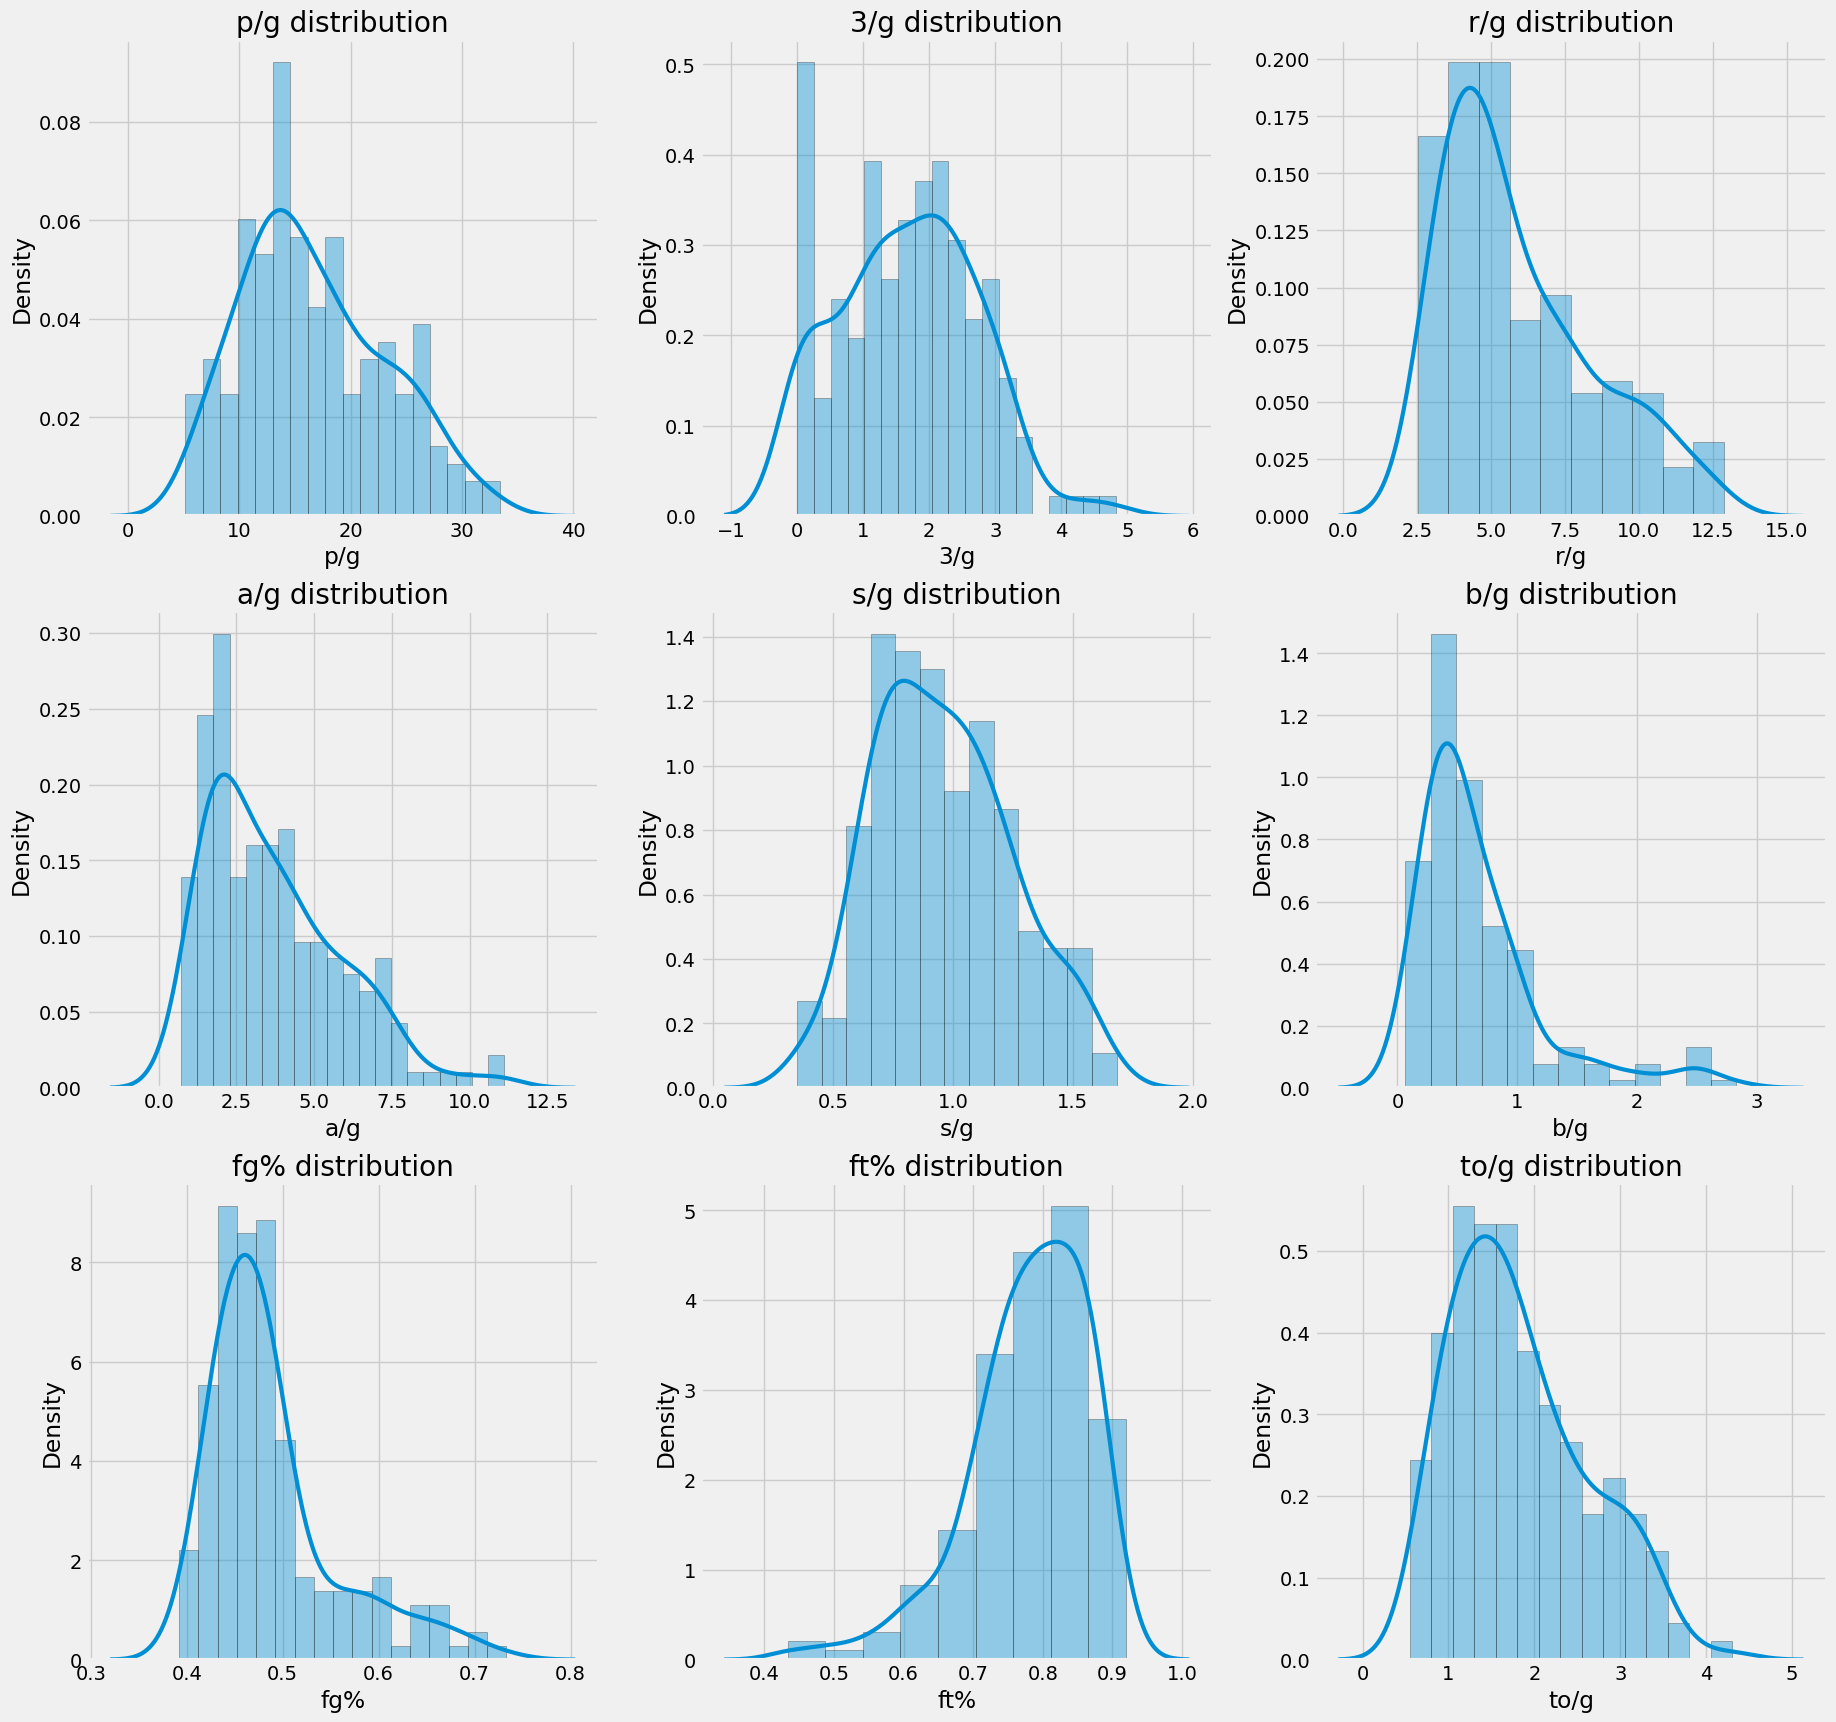

In [79]:
cats_dict = {'p/g':1.5,
             '3/g':0.25,
             'r/g':1,
             'a/g':0.5,
             's/g':0.1,
             'b/g':0.2,
             'fg%':0.02,
             'ft%':0.05,
             'to/g':0.25}



plt.figure(figsize=(20, 20))


for i, (cat, binwidth) in enumerate(cats_dict.items()):
    ax = plt.subplot(3, 3, i + 1)
    
    range_ = (max(excel_df[cat]) - min(excel_df[cat]))
    bins = int(range_ / binwidth)
    if bins == 0:
        bins = 15
    sns.distplot(excel_df[cat], hist = True, kde = True, 
                 kde_kws = {'linewidth': 3}, hist_kws={'edgecolor': 'black'}, bins=bins)

    ax.set_title(f'{cat} distribution')
    
plt.savefig('Graphs/9cat_dist.png', bbox_inches='tight')

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.417472,619.544453,629.123323,inf,0.049249,0.756106
gamma,0.420655,611.759953,621.338824,inf,0.063482,0.444519
chi2,0.420655,611.758250,621.337120,inf,0.063483,0.444510
rayleigh,0.485290,624.935421,631.321334,inf,0.140274,0.001493
cauchy,0.494576,692.746854,699.132768,inf,0.147143,0.000726


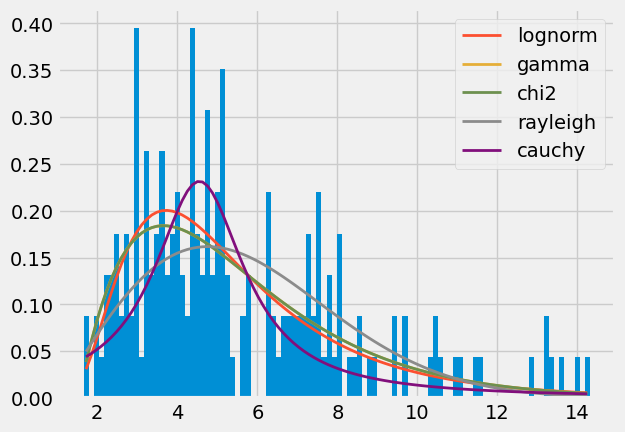

/Users/franhuzjan/Documents/NBA/random/venv/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/franhuzjan/Documents/NBA/random/venv/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [45]:
from sklearn import preprocessing
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions

blks = excel_df['to/g'].values
blks = stats.gamma.rvs(2, loc=1.5, scale=2, size=180)

f = Fitter(blks, distributions=get_common_distributions())

# f.get_best(method = 'sumsquare_error')

f.fit()
f.summary()

In [35]:
preprocessing.normalize([blks])

array([[0.16068995, 0.06884378, 0.10379399, 0.19201979, 0.08807618,
        0.04572694, 0.12026039, 0.1518883 , 0.09669026, 0.08437113,
        0.13339879, 0.06607853, 0.08628103, 0.02389807, 0.03762442,
        0.10675954, 0.07296897, 0.12562443, 0.11462699, 0.18758624,
        0.07163459, 0.08187767, 0.17105999, 0.11195508, 0.08457894,
        0.02557781, 0.0289126 , 0.13231305, 0.05772105, 0.03402888,
        0.0124704 , 0.02995324, 0.10981634, 0.04218615, 0.08722259,
        0.05376032, 0.0297346 , 0.06108334, 0.03781105, 0.03671085,
        0.02110853, 0.0989318 , 0.10646262, 0.03945036, 0.07719729,
        0.03078536, 0.14456898, 0.0356297 , 0.09299892, 0.12707207,
        0.11392057, 0.02936751, 0.0691702 , 0.0838013 , 0.07752969,
        0.02442794, 0.10256781, 0.03762496, 0.12232864, 0.06669772,
        0.02102692, 0.08641012, 0.0352899 , 0.06830233, 0.11450108,
        0.01526642, 0.05417342, 0.01614188, 0.01926973, 0.07562134,
        0.12517901, 0.09195432, 0.13866957, 0.09